## Eroding & Dilating 

In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import filters
from PIL import Image
import os
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

%load_ext autoreload
%autoreload 2

In [2]:
diamond = morphology.diamond(3) # Diamond shape kernel

In [3]:
images = os.listdir("./data/validation/predictions_segformer")

In [29]:
labels = []
preds_standard = []
preds_eroded = []
preds_dilated = []
preds_eroded_dilated = []
preds_dilated_eroded = []

# Process all validation images
for im in images:
    image = imread(f"./data/validation/predictions_segformer/{im}")
    image_binary = image > 0
    gt = imread(f"./data/validation/groundtruth/{im}")
    gt = np.round(gt/255)

    eroded = morphology.binary_erosion(image_binary, diamond) # Just eroded
    eroded_dilated = morphology.binary_dilation(eroded, diamond) # Eroded and then dilated
    dilated = morphology.binary_dilation(image_binary, diamond) # Just dilated
    dilated_eroded = morphology.binary_erosion(dilated, diamond) # Dilated and then eroded

    labels.extend(gt.flatten())
    preds_standard.extend(image_binary.flatten())
    preds_eroded.extend(eroded.flatten())
    preds_dilated.extend(dilated.flatten())
    preds_eroded_dilated.extend(eroded_dilated.flatten())
    preds_dilated_eroded.extend(dilated_eroded.flatten())


In [24]:
def evaluate_segmentation(pred, gt):
    """ Evaluate segmentation results """
    accuracy = accuracy_score(gt, pred)
    f1 = f1_score(gt, pred, pos_label=1)
    recall = recall_score(gt, pred, pos_label=1)
    precision = precision_score(gt, pred, pos_label=1)
    mean_iou = jaccard_score(gt, pred, average='macro')
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Mean IoU: {mean_iou}")
    # return accuracy, f1, recall, precision

In [30]:
evaluate_segmentation(preds_standard, labels)

Accuracy: 0.948439375
F1: 0.8765916516078075
Recall: 0.8642055602011005
Precision: 0.8893379490580613
Mean IoU: 0.858588701942361


In [ ]:
evaluate_segmentation(preds_eroded, labels)

Accuracy: 0.9333403125
F1: 0.8221232864718101
Recall: 0.7269879614021582
Precision: 0.9459068423335086
Mean IoU: 0.809586154926863


In [32]:
evaluate_segmentation(preds_dilated, labels)

Accuracy: 0.9348090625
F1: 0.8585259397254625
Recall: 0.9334905444726127
Precision: 0.7947064850015819
Mean IoU: 0.835427435247492


In [33]:
evaluate_segmentation(preds_eroded_dilated, labels)

Accuracy: 0.94856125
F1: 0.8767557757159372
Recall: 0.8634725964466743
Precision: 0.8904540221406704
Mean IoU: 0.8587993501113868


In [34]:
evaluate_segmentation(preds_dilated_eroded, labels)

Accuracy: 0.9484371875
F1: 0.8766459258639031
Recall: 0.8646760137980058
Precision: 0.888951894619378
Mean IoU: 0.8586265180458177


## Using Coditional Random Fields (CRF)

In [4]:
import numpy as np
import pydensecrf.densecrf as dcrf
import matplotlib.pyplot as plt
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
# import cv2
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
# from osgeo import gdal

import numpy as np
import os
import matplotlib.pyplot as plt
import random

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

from PIL import Image
# import evaluate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tqdm.notebook import tqdm
# import wandb

from mask_to_submission import masks_to_submission

from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from scipy.ndimage import rotate

%load_ext autoreload
%autoreload 2

/Users/arcivelekoglu/opt/anaconda3/envs/ml6/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load image processor and model

root_dir = './data'
image_processor = SegformerImageProcessor(reduce_labels=False, do_resize=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=2,
)

# Load the model state dict
model_path = "./models/finetuned_segformer_15_geocropdeg.pth" 
model.load_state_dict(torch.load(model_path, map_location=device))
print(f"Model state dict loaded from {model_path}")


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model state dict loaded from ./models/finetuned_segformer_15_geocropdeg.pth


In [6]:
images = os.listdir("./data/validation/predictions_segformer")

In [87]:
# Process all validation images
labels = []
preds_standard = []
preds_CRF = []
preds_eroded_dilated = []

diamond = morphology.diamond(4) 

for im in sorted(images):
    # Get image, segmentation and ground truth
    image = imread(f"./data/validation/images/{im}")
    segm = imread(f"./data/validation/predictions_segformer/{im}")
    segm_binary = segm > 0
    segm_binary = segm_binary.astype(float)
    segm_rgb = gray2rgb(segm)
    gt = imread(f"./data/validation/groundtruth/{im}")
    gt = np.round(gt/255)

    # Get the prediction probabilities

    model.eval() 
    image = Image.open(f"./data/validation/images/{im}")
    # Prepare the image for the model
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    logits = outputs.logits
    upsampled_logits = nn.functional.interpolate(logits, size=(400,400), mode="bilinear", align_corners=False)

    p = torch.nn.functional.softmax(upsampled_logits, dim=1)

    p = p[0].cpu().numpy()

    # Use the CRF to get the final prediction
    # Get the unary from the softmax output
    W, H, NLABELS = gt.shape[0], gt.shape[1], 2
    U = unary_from_softmax(p)

    # Horizontal kernel
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseGaussian(sxy=(4, 4), compat=4, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl1 = d.klDivergence(Q) / (H*W)
    map_soln_h = np.argmax(Q, axis=0).reshape((H,W))
    # Horizontal and vertical together
    map_soln = (map_soln_h) > 0
    soln_array = np.array(map_soln)
    soln_array = soln_array.astype(float)

    eroded = morphology.binary_erosion(soln_array, diamond)
    eroded_dilated = morphology.binary_dilation(eroded, diamond)

    # Get the metrics
    labels.extend(gt.flatten())
    preds_standard.extend(segm_binary.flatten())
    preds_CRF.extend(soln_array.flatten())
    preds_eroded_dilated.extend(eroded_dilated.flatten())

In [88]:
evaluate_segmentation(preds_standard, labels)

Accuracy: 0.948439375
F1: 0.8765916516078075
Recall: 0.8642055602011005
Precision: 0.8893379490580613
Mean IoU: 0.858588701942361


In [89]:
evaluate_segmentation(preds_CRF, labels)

Accuracy: 0.94873125
F1: 0.8770258945717794
Recall: 0.8627750273202285
Precision: 0.8917554452291272
Mean IoU: 0.8591232066859126


In [90]:
evaluate_segmentation(preds_eroded_dilated, labels)

Accuracy: 0.94877
F1: 0.8770333054800049
Recall: 0.8621821673015578
Precision: 0.8924050343074774
Mean IoU: 0.8591576109676053


In [79]:
def complete_process_base(sxy_param, compat_param, diamond_param=3):
    """ Complete process to evaluate the model with DenseCRF """
    labels = []
    preds_standard = []
    preds_CRF = []
    preds_eroded_dilated = []

    diamond = morphology.diamond(diamond_param) 

    for im in sorted(images):
        # Get image, segmentation and ground truth
        image = imread(f"./data/validation/images/{im}")
        segm = imread(f"./data/validation/predictions_segformer/{im}")
        segm_binary = segm > 0
        segm_binary = segm_binary.astype(float)
        segm_rgb = gray2rgb(segm)
        gt = imread(f"./data/validation/groundtruth/{im}")
        gt = np.round(gt/255)

        # Get the prediction probabilities

        model.eval() 
        image = Image.open(f"./data/validation/images/{im}")
        # Prepare the image for the model
        pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)

        logits = outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=gt.shape, mode="bilinear", align_corners=False)

        p = torch.nn.functional.softmax(upsampled_logits, dim=1)

        p = p[0].cpu().numpy()

        # Use the CRF to get the final prediction
        # Get the unary from the softmax output
        W, H, NLABELS = gt.shape[0], gt.shape[1], 2
        U = unary_from_softmax(p)

        # Gaussian
        d = dcrf.DenseCRF2D(W, H, NLABELS)
        d.setUnaryEnergy(U)
        #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        d.addPairwiseGaussian(sxy=(sxy_param, sxy_param), compat=compat_param, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        Q, tmp1, tmp2 = d.startInference()
        for _ in range(50):
            d.stepInference(Q, tmp1, tmp2)
        kl1 = d.klDivergence(Q) / (H*W)
        map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

        # Horizontal and vertical together
        map_soln = (map_soln_h) > 0
        soln_array = np.array(map_soln)
        soln_array = soln_array.astype(float)


        eroded = morphology.binary_erosion(soln_array, diamond)
        eroded_dilated = morphology.binary_dilation(eroded, diamond)

        # Get the metrics
        labels.extend(gt.flatten())
        preds_standard.extend(segm_binary.flatten())
        preds_CRF.extend(soln_array.flatten())
        preds_eroded_dilated.extend(eroded_dilated.flatten())
    
    f1_a = f1_score(labels, preds_CRF, pos_label=1) # F1 score with DenseCRF
    f1_b = f1_score(labels, preds_eroded_dilated, pos_label=1) # F1 score with DenseCRF AND eroding and dilating

    return f1_a, f1_b

In [80]:
# Hyperparameters search
sxy_params = [5, 10, 15, 20, 25, 30, 35, 40]
compat_params = [5, 10, 15, 20]

results_a = np.zeros((len(sxy_params), len(compat_params)))
results_b = np.zeros((len(sxy_params), len(compat_params)))

for i, sxy in enumerate(sxy_params):
    for j, compat in enumerate(compat_params):
        print(f"Evaluating sxy={sxy}, compat={compat}")
        f1_a, f1_b = complete_process_base(sxy, compat)
        results_a[i,j] = f1_a
        results_b[i,j] = f1_b

Evaluating sxy=5, compat=5
Evaluating sxy=5, compat=10
Evaluating sxy=5, compat=15
Evaluating sxy=5, compat=20
Evaluating sxy=10, compat=5
Evaluating sxy=10, compat=10
Evaluating sxy=10, compat=15
Evaluating sxy=10, compat=20
Evaluating sxy=15, compat=5
Evaluating sxy=15, compat=10
Evaluating sxy=15, compat=15
Evaluating sxy=15, compat=20
Evaluating sxy=20, compat=5
Evaluating sxy=20, compat=10
Evaluating sxy=20, compat=15
Evaluating sxy=20, compat=20
Evaluating sxy=25, compat=5
Evaluating sxy=25, compat=10
Evaluating sxy=25, compat=15
Evaluating sxy=25, compat=20
Evaluating sxy=30, compat=5
Evaluating sxy=30, compat=10
Evaluating sxy=30, compat=15
Evaluating sxy=30, compat=20
Evaluating sxy=35, compat=5
Evaluating sxy=35, compat=10
Evaluating sxy=35, compat=15
Evaluating sxy=35, compat=20
Evaluating sxy=40, compat=5
Evaluating sxy=40, compat=10
Evaluating sxy=40, compat=15
Evaluating sxy=40, compat=20


In [81]:
# Get best parameters

best_a = np.max(results_a)
best_b = np.max(results_b)

best_params_a = np.unravel_index(np.argmax(results_a, axis=None), results_a.shape)
best_params_b = np.unravel_index(np.argmax(results_b, axis=None), results_b.shape)

print(f"Best F1 score for CRF: {best_a}")
print(f"Best F1 score for Eroded-Dilated: {best_b}")
print(f"Best parameters for CRF: sxy={sxy_params[best_params_a[0]]}, compat={compat_params[best_params_a[1]]}")
print(f"Best parameters for Eroded-Dilated: sxy={sxy_params[best_params_b[0]]}, compat={compat_params[best_params_b[1]]}")

Best F1 score for CRF: 0.8764169134563978
Best F1 score for Eroded-Dilated: 0.8764121233242478
Best parameters for CRF: sxy=5, compat=5
Best parameters for Eroded-Dilated: sxy=5, compat=5


In [83]:
# Hyperparameters search
sxy_params = [1,2,3,4,5]
compat_params = [1,2,3,4,5]

results_a = np.zeros((len(sxy_params), len(compat_params)))
results_b = np.zeros((len(sxy_params), len(compat_params)))

for i, sxy in enumerate(sxy_params):
    for j, compat in enumerate(compat_params):
        print(f"Evaluating sxy={sxy}, compat={compat}")
        f1_a, f1_b = complete_process_base(sxy, compat)
        results_a[i,j] = f1_a
        results_b[i,j] = f1_b

Evaluating sxy=1, compat=1
Evaluating sxy=1, compat=2
Evaluating sxy=1, compat=3
Evaluating sxy=1, compat=4
Evaluating sxy=1, compat=5
Evaluating sxy=2, compat=1
Evaluating sxy=2, compat=2
Evaluating sxy=2, compat=3
Evaluating sxy=2, compat=4
Evaluating sxy=2, compat=5
Evaluating sxy=3, compat=1
Evaluating sxy=3, compat=2
Evaluating sxy=3, compat=3
Evaluating sxy=3, compat=4
Evaluating sxy=3, compat=5
Evaluating sxy=4, compat=1
Evaluating sxy=4, compat=2
Evaluating sxy=4, compat=3
Evaluating sxy=4, compat=4
Evaluating sxy=4, compat=5
Evaluating sxy=5, compat=1
Evaluating sxy=5, compat=2
Evaluating sxy=5, compat=3
Evaluating sxy=5, compat=4
Evaluating sxy=5, compat=5


In [84]:
# Get best parameters

best_a = np.max(results_a)
best_b = np.max(results_b)

best_params_a = np.unravel_index(np.argmax(results_a, axis=None), results_a.shape)
best_params_b = np.unravel_index(np.argmax(results_b, axis=None), results_b.shape)

print(f"Best F1 score for CRF: {best_a}")
print(f"Best F1 score for Eroded-Dilated: {best_b}")
print(f"Best parameters for CRF: sxy={sxy_params[best_params_a[0]]}, compat={compat_params[best_params_a[1]]}")
print(f"Best parameters for Eroded-Dilated: sxy={sxy_params[best_params_b[0]]}, compat={compat_params[best_params_b[1]]}")

Best F1 score for CRF: 0.8770662069853784
Best F1 score for Eroded-Dilated: 0.8769950601901103
Best parameters for CRF: sxy=2, compat=5
Best parameters for Eroded-Dilated: sxy=4, compat=4


In [85]:
diamond_params = [1, 2, 3, 4, 5]

results_a = np.zeros(len(diamond_params))
results_b = np.zeros(len(diamond_params))

for i, diamond in enumerate(diamond_params):
    print(f"Evaluating diamond={diamond}")
    f1_a, f1_b = complete_process_base(4, 4, diamond)
    results_a[i] = f1_a
    results_b[i] = f1_b

Evaluating diamond=1
Evaluating diamond=2
Evaluating diamond=3
Evaluating diamond=4
Evaluating diamond=5


In [86]:
# Get best parameters

best_a = np.max(results_a)
best_b = np.max(results_b)

best_params_a = np.argmax(results_a)
best_params_b = np.argmax(results_b)

print(f"Best F1 score for CRF: {best_a}")
print(f"Best F1 score for Eroded-Dilated: {best_b}")
print(f"Best parameters for CRF: diamond={diamond_params[best_params_a]}")
print(f"Best parameters for Eroded-Dilated: diamond={diamond_params[best_params_b]}")

Best F1 score for CRF: 0.8770258945717794
Best F1 score for Eroded-Dilated: 0.8770333054800049
Best parameters for CRF: diamond=1
Best parameters for Eroded-Dilated: diamond=4


## CRF with horizontal and vertical kernels

In [11]:
images = os.listdir("./data/validation/predictions_segformer")

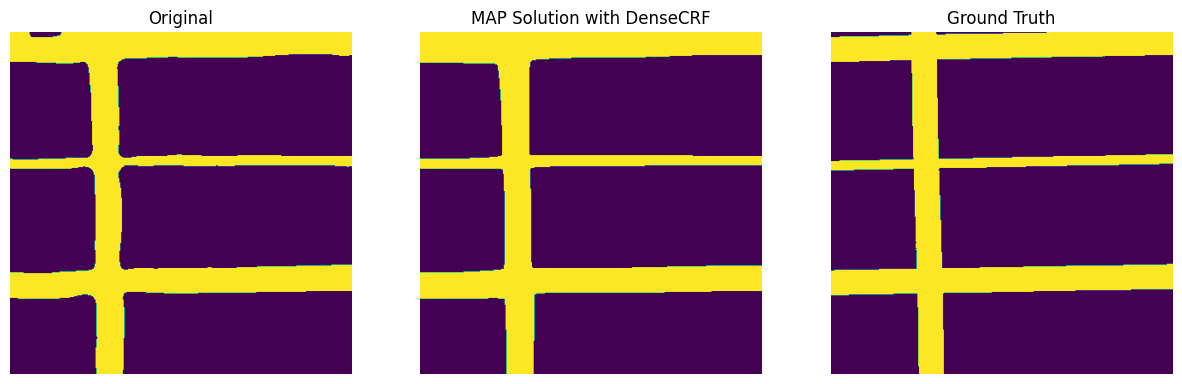

In [ ]:
# Get image, segmentation and ground truth
im = images[2]
image = imread(f"./data/validation/images/{im}")
segm = imread(f"./data/validation/predictions_segformer/{im}")
segm_binary = segm > 0
segm_binary = segm_binary.astype(float)
segm_rgb = gray2rgb(segm)
gt = imread(f"./data/validation/groundtruth/{im}")
gt = np.round(gt/255)

diamond = morphology.diamond(3) 

# Get the prediction probabilities

model.eval() 
image = Image.open(f"./data/validation/images/{im}")
# Prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

logits = outputs.logits
upsampled_logits = nn.functional.interpolate(logits, size=gt.shape, mode="bilinear", align_corners=False)

p = torch.nn.functional.softmax(upsampled_logits, dim=1)

p = p[0].cpu().numpy()

# Use the CRF to get the final prediction
# Get the unary from the softmax output
W, H, NLABELS = gt.shape[0], gt.shape[1], 2
U = unary_from_softmax(p)

# Horizontal kernel
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(U)
#d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
d.addPairwiseGaussian(sxy=(25, 1), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
#d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
Q, tmp1, tmp2 = d.startInference()
for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
kl1 = d.klDivergence(Q) / (H*W)
map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

# Vertical kernel
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(U)
d.addPairwiseGaussian(sxy=(1, 25), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
#d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
#d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
Q, tmp1, tmp2 = d.startInference()
for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
kl2 = d.klDivergence(Q) / (H*W)
map_soln_v = np.argmax(Q, axis=0).reshape((H,W))

# Horizontal and vertical together
map_soln = (map_soln_h + map_soln_v) > 0
soln_array = np.array(map_soln)
soln_array = soln_array.astype(float)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(segm_binary);
plt.title('Original'); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(map_soln);
plt.title('MAP Solution with DenseCRF'); plt.axis('off');
plt.subplot(1,3,3); plt.imshow(gt);
plt.title('Ground Truth'); plt.axis('off');
plt.show()

eroded = morphology.binary_erosion(soln_array, diamond)
eroded_dilated = morphology.binary_dilation(eroded, diamond)

In [ ]:
# Process all validation images
labels = []
preds_standard = []
preds_CRF = []
preds_eroded_dilated = []

diamond = morphology.diamond(3) 

for im in sorted(images):
    # Get image, segmentation and ground truth
    image = imread(f"./data/validation/images/{im}")
    segm = imread(f"./data/validation/predictions_segformer/{im}")
    segm_binary = segm > 0
    segm_binary = segm_binary.astype(float)
    segm_rgb = gray2rgb(segm)
    gt = imread(f"./data/validation/groundtruth/{im}")
    gt = np.round(gt/255)

    # Get the prediction probabilities

    model.eval() 
    image = Image.open(f"./data/validation/images/{im}")
    # Prepare the image for the model
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    logits = outputs.logits
    upsampled_logits = nn.functional.interpolate(logits, size=(400,400), mode="bilinear", align_corners=False)

    p = torch.nn.functional.softmax(upsampled_logits, dim=1)

    p = p[0].cpu().numpy()

    # Use the CRF to get the final prediction
    # Get the unary from the softmax output
    W, H, NLABELS = gt.shape[0], gt.shape[1], 2
    U = unary_from_softmax(p)

    # Horizontal kernel
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseGaussian(sxy=(35, 1), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl1 = d.klDivergence(Q) / (H*W)
    map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

    # Vertical kernel
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=(1, 35), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl2 = d.klDivergence(Q) / (H*W)
    map_soln_v = np.argmax(Q, axis=0).reshape((H,W))

    # Horizontal and vertical together
    map_soln = (map_soln_h + map_soln_v) > 0
    soln_array = np.array(map_soln)
    soln_array = soln_array.astype(float)

    # plt.figure(figsize=(15,5))
    # plt.subplot(1,3,1); plt.imshow(segm_binary);
    # plt.title('Original'); plt.axis('off');
    # plt.subplot(1,3,2); plt.imshow(map_soln);
    # plt.title('MAP Solution with DenseCRF'); plt.axis('off');
    # plt.subplot(1,3,3); plt.imshow(gt);
    # plt.title('Ground Truth'); plt.axis('off');
    # plt.show()

    eroded = morphology.binary_erosion(soln_array, diamond)
    eroded_dilated = morphology.binary_dilation(eroded, diamond)

    # Get the metrics
    labels.extend(gt.flatten())
    preds_standard.extend(segm_binary.flatten())
    preds_CRF.extend(soln_array.flatten())
    preds_eroded_dilated.extend(eroded_dilated.flatten())

In [25]:
evaluate_segmentation(preds_standard, labels)

Accuracy: 0.948439375
F1: 0.8765916516078075
Recall: 0.8642055602011005
Precision: 0.8893379490580613
Mean IoU: 0.858588701942361


In [26]:
evaluate_segmentation(preds_CRF, labels)

Accuracy: 0.9530921875
F1: 0.8883123222152859
Recall: 0.8803425610078031
Precision: 0.8964277025748534
Mean IoU: 0.8707008881217266


In [27]:
evaluate_segmentation(preds_eroded_dilated, labels)

Accuracy: 0.953000625
F1: 0.8880345787170557
Recall: 0.8795977990440501
Precision: 0.8966347707780542
Mean IoU: 0.8704255289162399


In [ ]:
def complete_process(sxy_param, compat_param, diamond_param=3):
    """ Complete process to evaluate the model with DenseCRF """
    labels = []
    preds_standard = []
    preds_CRF = []
    preds_eroded_dilated = []

    diamond = morphology.diamond(diamond_param) 

    for im in sorted(images):
        # Get image, segmentation and ground truth
        image = imread(f"./data/validation/images/{im}")
        segm = imread(f"./data/validation/predictions_segformer/{im}")
        segm_binary = segm > 0
        segm_binary = segm_binary.astype(float)
        segm_rgb = gray2rgb(segm)
        gt = imread(f"./data/validation/groundtruth/{im}")
        gt = np.round(gt/255)

        # Get the prediction probabilities

        model.eval() 
        image = Image.open(f"./data/validation/images/{im}")
        # Prepare the image for the model
        pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)

        logits = outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=gt.shape, mode="bilinear", align_corners=False)

        p = torch.nn.functional.softmax(upsampled_logits, dim=1)

        p = p[0].cpu().numpy()

        # Use the CRF to get the final prediction
        # Get the unary from the softmax output
        W, H, NLABELS = gt.shape[0], gt.shape[1], 2
        U = unary_from_softmax(p)

        # Horizontal kernel
        d = dcrf.DenseCRF2D(W, H, NLABELS)
        d.setUnaryEnergy(U)
        #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        d.addPairwiseGaussian(sxy=(sxy_param, 1), compat=compat_param, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        Q, tmp1, tmp2 = d.startInference()
        for _ in range(50):
            d.stepInference(Q, tmp1, tmp2)
        kl1 = d.klDivergence(Q) / (H*W)
        map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

        # Vertical kernel
        d = dcrf.DenseCRF2D(W, H, NLABELS)
        d.setUnaryEnergy(U)
        d.addPairwiseGaussian(sxy=(1, sxy_param), compat=compat_param, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        Q, tmp1, tmp2 = d.startInference()
        for _ in range(50):
            d.stepInference(Q, tmp1, tmp2)
        kl2 = d.klDivergence(Q) / (H*W)
        map_soln_v = np.argmax(Q, axis=0).reshape((H,W))

        # Horizontal and vertical together
        map_soln = (map_soln_h + map_soln_v) > 0
        soln_array = np.array(map_soln)
        soln_array = soln_array.astype(float)

        # plt.figure(figsize=(15,5))
        # plt.subplot(1,3,1); plt.imshow(segm_binary);
        # plt.title('Original'); plt.axis('off');
        # plt.subplot(1,3,2); plt.imshow(map_soln);
        # plt.title('MAP Solution with DenseCRF'); plt.axis('off');
        # plt.subplot(1,3,3); plt.imshow(gt);
        # plt.title('Ground Truth'); plt.axis('off');
        # plt.show()

        eroded = morphology.binary_erosion(soln_array, diamond)
        eroded_dilated = morphology.binary_dilation(eroded, diamond)

        # Get the metrics
        labels.extend(gt.flatten())
        preds_standard.extend(segm_binary.flatten())
        preds_CRF.extend(soln_array.flatten())
        preds_eroded_dilated.extend(eroded_dilated.flatten())
    
    f1_a = f1_score(labels, preds_CRF, pos_label=1) # F1 score with DenseCRF
    f1_b = f1_score(labels, preds_eroded_dilated, pos_label=1) # F1 score with DenseCRF AND eroding and dilating

    return f1_a, f1_b

In [338]:
# Hyperparameters search
sxy_params = [5, 20, 40, 60, 80, 100]
compat_params = [5, 10, 15, 20, 25, 30]

results_a = np.zeros((len(sxy_params), len(compat_params)))
results_b = np.zeros((len(sxy_params), len(compat_params)))

for i, sxy in enumerate(sxy_params):
    for j, compat in enumerate(compat_params):
        print(f"Evaluating sxy={sxy}, compat={compat}")
        f1_a, f1_b = complete_process(sxy, compat)
        results_a[i,j] = f1_a
        results_b[i,j] = f1_b

Evaluating sxy=5, compat=5
Evaluating sxy=5, compat=10
Evaluating sxy=5, compat=15
Evaluating sxy=5, compat=20
Evaluating sxy=5, compat=25
Evaluating sxy=5, compat=30
Evaluating sxy=20, compat=5
Evaluating sxy=20, compat=10
Evaluating sxy=20, compat=15
Evaluating sxy=20, compat=20
Evaluating sxy=20, compat=25
Evaluating sxy=20, compat=30
Evaluating sxy=40, compat=5
Evaluating sxy=40, compat=10
Evaluating sxy=40, compat=15
Evaluating sxy=40, compat=20
Evaluating sxy=40, compat=25
Evaluating sxy=40, compat=30
Evaluating sxy=60, compat=5
Evaluating sxy=60, compat=10
Evaluating sxy=60, compat=15
Evaluating sxy=60, compat=20
Evaluating sxy=60, compat=25
Evaluating sxy=60, compat=30
Evaluating sxy=80, compat=5
Evaluating sxy=80, compat=10
Evaluating sxy=80, compat=15
Evaluating sxy=80, compat=20
Evaluating sxy=80, compat=25
Evaluating sxy=80, compat=30
Evaluating sxy=100, compat=5
Evaluating sxy=100, compat=10
Evaluating sxy=100, compat=15
Evaluating sxy=100, compat=20
Evaluating sxy=100, co

In [340]:
# Get best parameters

best_a = np.max(results_a)
best_b = np.max(results_b)

best_params_a = np.unravel_index(np.argmax(results_a, axis=None), results_a.shape)
best_params_b = np.unravel_index(np.argmax(results_b, axis=None), results_b.shape)

print(f"Best F1 score for CRF: {best_a}")
print(f"Best F1 score for Eroded-Dilated: {best_b}")
print(f"Best parameters for CRF: sxy={sxy_params[best_params_a[0]]}, compat={compat_params[best_params_a[1]]}")
print(f"Best parameters for Eroded-Dilated: sxy={sxy_params[best_params_b[0]]}, compat={compat_params[best_params_b[1]]}")

Best F1 score for CRF: 0.8882229306708231
Best F1 score for Eroded-Dilated: 0.8882004410632572
Best parameters for CRF: sxy=40, compat=10
Best parameters for Eroded-Dilated: sxy=40, compat=10


In [343]:
# Hyperparameters search
sxy_params = [25, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50]
compat_params = [5, 10, 15, 20]

results_a = np.zeros((len(sxy_params), len(compat_params)))
results_b = np.zeros((len(sxy_params), len(compat_params)))

for i, sxy in enumerate(sxy_params):
    for j, compat in enumerate(compat_params):
        print(f"Evaluating sxy={sxy}, compat={compat}")
        f1_a, f1_b = complete_process(sxy, compat)
        results_a[i,j] = f1_a
        results_b[i,j] = f1_b

Evaluating sxy=25, compat=5
Evaluating sxy=25, compat=10
Evaluating sxy=25, compat=15
Evaluating sxy=25, compat=20
Evaluating sxy=30, compat=5
Evaluating sxy=30, compat=10
Evaluating sxy=30, compat=15
Evaluating sxy=30, compat=20
Evaluating sxy=32.5, compat=5
Evaluating sxy=32.5, compat=10
Evaluating sxy=32.5, compat=15
Evaluating sxy=32.5, compat=20
Evaluating sxy=35, compat=5
Evaluating sxy=35, compat=10
Evaluating sxy=35, compat=15
Evaluating sxy=35, compat=20
Evaluating sxy=37.5, compat=5
Evaluating sxy=37.5, compat=10
Evaluating sxy=37.5, compat=15
Evaluating sxy=37.5, compat=20
Evaluating sxy=40, compat=5
Evaluating sxy=40, compat=10
Evaluating sxy=40, compat=15
Evaluating sxy=40, compat=20
Evaluating sxy=42.5, compat=5
Evaluating sxy=42.5, compat=10
Evaluating sxy=42.5, compat=15
Evaluating sxy=42.5, compat=20
Evaluating sxy=45, compat=5
Evaluating sxy=45, compat=10
Evaluating sxy=45, compat=15
Evaluating sxy=45, compat=20
Evaluating sxy=47.5, compat=5
Evaluating sxy=47.5, compa

In [344]:
# Get best parameters

best_a = np.max(results_a)
best_b = np.max(results_b)

best_params_a = np.unravel_index(np.argmax(results_a, axis=None), results_a.shape)
best_params_b = np.unravel_index(np.argmax(results_b, axis=None), results_b.shape)

print(f"Best F1 score for CRF: {best_a}")
print(f"Best F1 score for Eroded-Dilated: {best_b}")
print(f"Best parameters for CRF: sxy={sxy_params[best_params_a[0]]}, compat={compat_params[best_params_a[1]]}")
print(f"Best parameters for Eroded-Dilated: sxy={sxy_params[best_params_b[0]]}, compat={compat_params[best_params_b[1]]}")

Best F1 score for CRF: 0.8883123222152859
Best F1 score for Eroded-Dilated: 0.8882004410632572
Best parameters for CRF: sxy=35, compat=15
Best parameters for Eroded-Dilated: sxy=40, compat=10


In [348]:
diamond_params = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

results_a = np.zeros(len(diamond_params))
results_b = np.zeros(len(diamond_params))

for i, diamond in enumerate(diamond_params):
    print(f"Evaluating diamond={diamond}")
    f1_a, f1_b = complete_process(35, 15, diamond)
    results_a[i] = f1_a
    results_b[i] = f1_b

Evaluating diamond=1
Evaluating diamond=2
Evaluating diamond=3
Evaluating diamond=4
Evaluating diamond=5
Evaluating diamond=6
Evaluating diamond=7
Evaluating diamond=8
Evaluating diamond=9
Evaluating diamond=10


In [349]:
# Get best parameters

best_a = np.max(results_a)
best_b = np.max(results_b)

best_params_a = np.argmax(results_a)
best_params_b = np.argmax(results_b)

print(f"Best F1 score for CRF: {best_a}")
print(f"Best F1 score for Eroded-Dilated: {best_b}")
print(f"Best parameters for CRF: diamond={diamond_params[best_params_a]}")
print(f"Best parameters for Eroded-Dilated: diamond={diamond_params[best_params_b]}")

Best F1 score for CRF: 0.8883123222152859
Best F1 score for Eroded-Dilated: 0.8883071812943474
Best parameters for CRF: diamond=1
Best parameters for Eroded-Dilated: diamond=1


In [ ]:
# Post process test set

images_test = sorted(os.listdir("./data/test"))
images_test = [im for im in images_test if im.startswith("test")]
images_test = [im for im in images_test if os.path.isdir(f"./data/test/{im}")]

diamond = morphology.diamond(3) 

for im in images_test:
    print(im)
    # Open the image and the segmentation map
    image = imread(f"./data/test/{im}/{im}.png")
    segm = imread(f"./data/test/{im}/{im}_pred_segformer_ft_geocropdeg_15.png")
    segm_binary = segm > 0
    segm_binary = segm_binary.astype(float)
    segm_rgb = gray2rgb(segm)

    # Get the prediction probabilities
    model.eval() 
    image = Image.open(f"./data/test/{im}/{im}.png")
    # Prepare the image for the model
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    logits = outputs.logits
    upsampled_logits = nn.functional.interpolate(logits, size=segm.shape, mode="bilinear", align_corners=False)

    p = torch.nn.functional.softmax(upsampled_logits, dim=1)
    p = p[0].cpu().numpy()

    # Use the CRF to get the final prediction
    # Get the unary from the softmax output
    W, H, NLABELS = segm.shape[0], segm.shape[1], 2
    U = unary_from_softmax(p)

    # Horizontal
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseGaussian(sxy=(35, 1), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl1 = d.klDivergence(Q) / (H*W)
    map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

    # Vertical
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=(1, 35), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl2 = d.klDivergence(Q) / (H*W)
    map_soln_v = np.argmax(Q, axis=0).reshape((H,W))

    # Together
    map_soln = (map_soln_h + map_soln_v) > 0
    # Can also add original segmentation to regain the diagonal roads lost in the CRF
    # map_soln = (map_soln_h + map_soln_v + segm_binary) > 0
    soln_array = np.array(map_soln)
    soln_array = soln_array.astype(float)

    # plt.figure(figsize=(15,5))
    # plt.subplot(1,3,1); plt.imshow(segm_binary);
    # plt.title('Original'); plt.axis('off');
    # plt.subplot(1,3,2); plt.imshow(map_soln);
    # plt.title('MAP Solution with DenseCRF'); plt.axis('off');
    # plt.subplot(1,3,3); plt.imshow(gt);
    # plt.title('Ground Truth'); plt.axis('off');
    # plt.show()

    # Added in case of posprocessing2 - adding back of segm_binary
    # eroded = morphology.binary_erosion(soln_array, diamond)
    # soln_array = morphology.binary_dilation(eroded, diamond)

    soln_array = soln_array*255
    soln_array = soln_array.astype(np.uint8)

    # Save the segmentation map
    segm_im = Image.fromarray(soln_array)
    segm_im.save(f"./data/test/{im}/{im}_postprocessed_pred_segformer_ft_geocropdeg_15.png")

print("Test images processed. Creating submission file...")

# Create submission file
submission_filename = 'submission_postprocessed_segformer_ft_geocropdeg_15.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = f"./data/test/test_{i}/test_{i}_postprocessed_pred_segformer_ft_geocropdeg_15.png"
    # print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

print("Submission file created. Done!")

## Improvements on CRF by using diagonal kernels too

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [8]:
def edge_power(gradient_x, gradient_y, diagonal=False):
    """ Compute a sense of the power of the edges in the image """
    if diagonal:
        compass_operators = [np.array([[-1, -1,  2], [-1,  2, -1], [ 2, -1, -1]]),
                            np.array([[2, -1,  -1], [-1,  2, -1], [ -1, -1, 2]]),
                            # ... add more compass operators as needed
                            ]
    else:
        compass_operators = [np.array([[-1, -1,  -1], [-1,  8, -1], [ -1, -1, -1]]),
                            # ... add more compass operators as needed
                            ]
        # compass_operators = [np.array([[-1, 2, -1], [-1,  2, -1], [ -1, 2, -1]]),
        #                     np.array([[-1, -1,  -1], [2,  2, 2], [ -1, -1, -1]]),
        #                     # ... add more compass operators as needed
        #                     ]

    edge_responses = [cv2.filter2D(gradient_x, cv2.CV_64F, kernel) +
                        cv2.filter2D(gradient_y, cv2.CV_64F, kernel)
                        for kernel in compass_operators]
    
    non_max_suppressed = np.max(edge_responses, axis=0)

    threshold = 1
    edges = non_max_suppressed >= threshold

    return sum(edges.flatten())


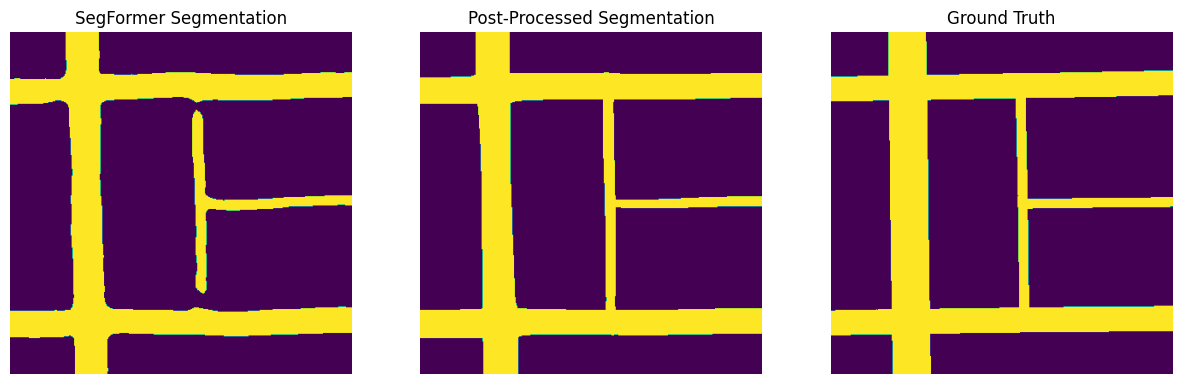

In [26]:
# Get image, segmentation and ground truth
diag_coef = 0.8
im = images[0]
image = imread(f"./data/validation/images/{im}")
segm = imread(f"./data/validation/predictions_segformer/{im}")
segm_binary = segm > 0
segm_binary = segm_binary.astype(float)
segm_rgb = gray2rgb(segm)
gt = imread(f"./data/validation/groundtruth/{im}")
gt = np.round(gt/255)

# Use edge detection to see if the image has a diagonal road
original_image = cv2.imread(f"./data/validation/predictions_segformer/{im}", cv2.IMREAD_GRAYSCALE)
gradient_x = cv2.Sobel(original_image, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(original_image, cv2.CV_64F, 0, 1, ksize=3)

standard_weight = edge_power(gradient_x, gradient_y, diagonal=False)
diagonal_weight = edge_power(gradient_x, gradient_y, diagonal=True)

# Get the prediction probabilities
model.eval() 
image = Image.open(f"./data/validation/images/{im}")
# Prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

logits = outputs.logits
upsampled_logits = nn.functional.interpolate(logits, size=gt.shape, mode="bilinear", align_corners=False)

p = torch.nn.functional.softmax(upsampled_logits, dim=1)

p = p[0].cpu().numpy()

if diagonal_weight >= diag_coef*standard_weight:
    # Add zero padding around
    p_pad = np.pad(p, ((0,0),(400,400),(400,400)), mode='constant')
    segm_pad = np.pad(segm, ((400,400),(400,400)), mode='constant')

    # Use the CRF to get the final prediction
    # Get the unary from the softmax output
    W, H, NLABELS = segm_pad.shape[0], segm_pad.shape[1], 2
    U = unary_from_softmax(p_pad)
else:
    W, H, NLABELS = segm.shape[0], segm.shape[1], 2
    U = unary_from_softmax(p)

# Horizontal
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(U)
#d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
d.addPairwiseGaussian(sxy=(35, 1), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
#d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
Q, tmp1, tmp2 = d.startInference()
for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
kl1 = d.klDivergence(Q) / (H*W)
map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

# Vertical
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(U)
d.addPairwiseGaussian(sxy=(1, 35), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
#d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
#d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
Q, tmp1, tmp2 = d.startInference()
for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
kl2 = d.klDivergence(Q) / (H*W)
map_soln_v = np.argmax(Q, axis=0).reshape((H,W))

map_soln = map_soln_h + map_soln_v


if diagonal_weight >= diag_coef*standard_weight:
    print(f"Image {im} has a diagonal edge")
    # Evaluate the CRF with different rotations
    rotations = [45]
    for rot in rotations:
        # Rotate the probs by rot degrees
        rotated_p = np.array([rotate(p_pad[i], rot, reshape=False) for i in range(2)])
        rotated_U = unary_from_softmax(rotated_p)

        # Horizontal
        d = dcrf.DenseCRF2D(W, H, NLABELS)
        d.setUnaryEnergy(rotated_U)
        #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        d.addPairwiseGaussian(sxy=(40, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        Q, tmp1, tmp2 = d.startInference()
        for _ in range(50):
            d.stepInference(Q, tmp1, tmp2)
        kl1 = d.klDivergence(Q) / (H*W)
        map_soln_1 = np.argmax(Q, axis=0).reshape((H,W))
        map_soln_1 = rotate(map_soln_1, -rot, reshape=False)

        # # Vertical
        d = dcrf.DenseCRF2D(W, H, NLABELS)
        d.setUnaryEnergy(rotated_U)
        d.addPairwiseGaussian(sxy=(1, 40), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        Q, tmp1, tmp2 = d.startInference()
        for _ in range(50):
            d.stepInference(Q, tmp1, tmp2)
        kl2 = d.klDivergence(Q) / (H*W)
        map_soln_2 = np.argmax(Q, axis=0).reshape((H,W))
        map_soln_2 = rotate(map_soln_2, -rot, reshape=False)

        map_soln = map_soln + map_soln_1 + map_soln_2

# Together
map_soln = map_soln > 0
soln_array = np.array(map_soln)
soln_array = soln_array.astype(float)
if diagonal_weight >= diag_coef*standard_weight:
    soln_array = soln_array[400:-400, 400:-400]

# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1); plt.imshow(segm_binary);
# plt.title('Original'); plt.axis('off');
# plt.subplot(1,3,2); plt.imshow(map_soln);
# plt.title('MAP Solution with DenseCRF'); plt.axis('off');
# plt.subplot(1,3,3); plt.imshow(gt);
# plt.title('Ground Truth'); plt.axis('off');
# plt.show()

eroded = morphology.binary_erosion(soln_array, diamond)
eroded_dilated = morphology.binary_dilation(eroded, diamond)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(segm_binary);
plt.title('SegFormer Segmentation'); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(eroded_dilated);
plt.title('Post-Processed Segmentation'); plt.axis('off');
plt.subplot(1,3,3); plt.imshow(gt);
plt.title('Ground Truth'); plt.axis('off');
plt.show()

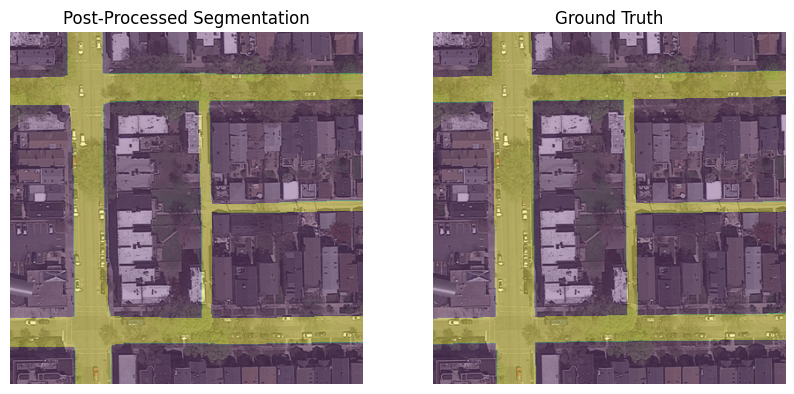

In [27]:
# Overlay segmentation with image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(eroded_dilated, alpha=0.7); plt.imshow(image, alpha=0.5);
plt.title('Post-Processed Segmentation'); plt.axis('off');
plt.subplot(1,2,2); plt.imshow(gt, alpha=0.7); plt.imshow(image, alpha=0.5);
plt.title('Ground Truth'); plt.axis('off');
plt.show()


In [68]:
# Process all validation images
labels = []
preds_standard = []
preds_CRF = []
preds_eroded_dilated = []

diamond = morphology.diamond(3)
diag_coef = 0.8

for im in sorted(images):
    print(f"Evaluating image {im}")
    # Get image, segmentation and ground truth
    image = imread(f"./data/validation/images/{im}")
    segm = imread(f"./data/validation/predictions_segformer/{im}")
    segm_binary = segm > 0
    segm_binary = segm_binary.astype(float)
    segm_rgb = gray2rgb(segm)
    gt = imread(f"./data/validation/groundtruth/{im}")
    gt = np.round(gt/255)

    # Use edge detection to see if the image has a diagonal road
    original_image = cv2.imread(f"./data/validation/predictions_segformer/{im}", cv2.IMREAD_GRAYSCALE)
    gradient_x = cv2.Sobel(original_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(original_image, cv2.CV_64F, 0, 1, ksize=3)

    standard_weight = edge_power(gradient_x, gradient_y, diagonal=False)
    diagonal_weight = edge_power(gradient_x, gradient_y, diagonal=True)

    # Get the prediction probabilities
    model.eval() 
    image = Image.open(f"./data/validation/images/{im}")
    # Prepare the image for the model
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    logits = outputs.logits
    upsampled_logits = nn.functional.interpolate(logits, size=gt.shape, mode="bilinear", align_corners=False)

    p = torch.nn.functional.softmax(upsampled_logits, dim=1)

    p = p[0].cpu().numpy()

    if diagonal_weight >= diag_coef*standard_weight:
        # Add zero padding around
        p_pad = np.pad(p, ((0,0),(400,400),(400,400)), mode='constant')
        segm_pad = np.pad(segm, ((400,400),(400,400)), mode='constant')

        # Use the CRF to get the final prediction
        # Get the unary from the softmax output
        W, H, NLABELS = segm_pad.shape[0], segm_pad.shape[1], 2
        U = unary_from_softmax(p_pad)
    else:
        W, H, NLABELS = segm.shape[0], segm.shape[1], 2
        U = unary_from_softmax(p)

    # Horizontal
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseGaussian(sxy=(35, 1), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl1 = d.klDivergence(Q) / (H*W)
    map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

    # Vertical
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=(1, 35), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl2 = d.klDivergence(Q) / (H*W)
    map_soln_v = np.argmax(Q, axis=0).reshape((H,W))

    map_soln = map_soln_h + map_soln_v


    if diagonal_weight >= diag_coef*standard_weight:
        print(f"Image {im} has a diagonal edge")
        # Evaluate the CRF with different rotations
        rotations = [45]
        for rot in rotations:
            # Rotate the probs by rot degrees
            rotated_p = np.array([rotate(p_pad[i], rot, reshape=False) for i in range(2)])
            rotated_U = unary_from_softmax(rotated_p)

            # Horizontal
            d = dcrf.DenseCRF2D(W, H, NLABELS)
            d.setUnaryEnergy(rotated_U)
            #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            d.addPairwiseGaussian(sxy=(40, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            Q, tmp1, tmp2 = d.startInference()
            for _ in range(50):
                d.stepInference(Q, tmp1, tmp2)
            kl1 = d.klDivergence(Q) / (H*W)
            map_soln_1 = np.argmax(Q, axis=0).reshape((H,W))
            map_soln_1 = rotate(map_soln_1, -rot, reshape=False)

            # # Vertical
            d = dcrf.DenseCRF2D(W, H, NLABELS)
            d.setUnaryEnergy(rotated_U)
            d.addPairwiseGaussian(sxy=(1, 40), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            Q, tmp1, tmp2 = d.startInference()
            for _ in range(50):
                d.stepInference(Q, tmp1, tmp2)
            kl2 = d.klDivergence(Q) / (H*W)
            map_soln_2 = np.argmax(Q, axis=0).reshape((H,W))
            map_soln_2 = rotate(map_soln_2, -rot, reshape=False)

            map_soln = map_soln + map_soln_1 + map_soln_2

    # Together
    map_soln = map_soln > 0
    soln_array = np.array(map_soln)
    soln_array = soln_array.astype(float)
    if diagonal_weight >= diag_coef*standard_weight:
        soln_array = soln_array[400:-400, 400:-400]

    # plt.figure(figsize=(15,5))
    # plt.subplot(1,3,1); plt.imshow(segm_binary);
    # plt.title('Original'); plt.axis('off');
    # plt.subplot(1,3,2); plt.imshow(map_soln);
    # plt.title('MAP Solution with DenseCRF'); plt.axis('off');
    # plt.subplot(1,3,3); plt.imshow(gt);
    # plt.title('Ground Truth'); plt.axis('off');
    # plt.show()

    eroded = morphology.binary_erosion(soln_array, diamond)
    eroded_dilated = morphology.binary_dilation(eroded, diamond)

    # Get the metrics
    labels.extend(gt.flatten())
    preds_standard.extend(segm_binary.flatten())
    preds_CRF.extend(soln_array.flatten())
    preds_eroded_dilated.extend(eroded_dilated.flatten())

Evaluating image satImage_081.png
Evaluating image satImage_082.png
Evaluating image satImage_083.png
Image satImage_083.png has a diagonal edge
Evaluating image satImage_084.png
Evaluating image satImage_085.png
Evaluating image satImage_086.png
Evaluating image satImage_087.png
Evaluating image satImage_088.png
Image satImage_088.png has a diagonal edge
Evaluating image satImage_089.png
Evaluating image satImage_090.png
Image satImage_090.png has a diagonal edge
Evaluating image satImage_091.png
Image satImage_091.png has a diagonal edge
Evaluating image satImage_092.png
Image satImage_092.png has a diagonal edge
Evaluating image satImage_093.png
Evaluating image satImage_094.png
Evaluating image satImage_095.png
Evaluating image satImage_096.png
Evaluating image satImage_097.png
Evaluating image satImage_098.png
Evaluating image satImage_099.png
Evaluating image satImage_100.png


In [69]:
evaluate_segmentation(preds_standard, labels)

Accuracy: 0.948439375
F1: 0.8765916516078075
Recall: 0.8642055602011005
Precision: 0.8893379490580613
Mean IoU: 0.858588701942361


In [70]:
evaluate_segmentation(preds_CRF, labels)

Accuracy: 0.9529334375
F1: 0.8885024566577757
Recall: 0.8850176014535394
Precision: 0.8920148643626904
Mean IoU: 0.8707219127879059


In [71]:
evaluate_segmentation(preds_eroded_dilated, labels)

Accuracy: 0.9530159375
F1: 0.8886065239151196
Recall: 0.8843952459115517
Precision: 0.8928580999997022
Mean IoU: 0.8708616202494001


In [73]:
def complete_process_2(sxy_param, compat_param, sxy_param_diag, compat_param_diag, diamond_param=3):
    """ Complete process to evaluate the model with DenseCRF, including rotations for diagonals """
    labels = []
    preds_standard = []
    preds_CRF = []
    preds_eroded_dilated = []

    diamond = morphology.diamond(diamond_param) 

    for im in sorted(images):
        # Get image, segmentation and ground truth
        image = imread(f"/Users/arcivelekoglu/Desktop/EPFL/MA3/Machine learning/ML_AGA/data/validation/images/{im}")
        segm = imread(f"/Users/arcivelekoglu/Desktop/EPFL/MA3/Machine learning/ML_AGA/data/validation/predictions_segformer/{im}")
        segm_binary = segm > 0
        segm_binary = segm_binary.astype(float)
        segm_rgb = gray2rgb(segm)
        gt = imread(f"/Users/arcivelekoglu/Desktop/EPFL/MA3/Machine learning/ML_AGA/data/validation/groundtruth/{im}")
        gt = np.round(gt/255)

        # Use edge detection to see if the image has a diagonal road
        original_image = cv2.imread(f"/Users/arcivelekoglu/Desktop/EPFL/MA3/Machine learning/ML_AGA/data/validation/predictions_segformer/{im}", cv2.IMREAD_GRAYSCALE)
        gradient_x = cv2.Sobel(original_image, cv2.CV_64F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(original_image, cv2.CV_64F, 0, 1, ksize=3)

        standard_weight = edge_power(gradient_x, gradient_y, diagonal=False)
        diagonal_weight = edge_power(gradient_x, gradient_y, diagonal=True)

        # Get the prediction probabilities

        model.eval() 
        image = Image.open(f"./data/validation/images/{im}")
        # Prepare the image for the model
        pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)

        logits = outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=gt.shape, mode="bilinear", align_corners=False)

        p = torch.nn.functional.softmax(upsampled_logits, dim=1)

        p = p[0].cpu().numpy()

        diag_coef = 0.8
        if diagonal_weight >= diag_coef*standard_weight:
            # Add zero padding around
            p_pad = np.pad(p, ((0,0),(400,400),(400,400)), mode='constant')
            segm_pad = np.pad(segm, ((400,400),(400,400)), mode='constant')

            # Use the CRF to get the final prediction
            # Get the unary from the softmax output
            W, H, NLABELS = segm_pad.shape[0], segm_pad.shape[1], 2
            U = unary_from_softmax(p_pad)
        else:
            W, H, NLABELS = segm.shape[0], segm.shape[1], 2
            U = unary_from_softmax(p)

        # Horizontal
        d = dcrf.DenseCRF2D(W, H, NLABELS)
        d.setUnaryEnergy(U)
        #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        d.addPairwiseGaussian(sxy=(sxy_param, 1), compat=compat_param, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        Q, tmp1, tmp2 = d.startInference()
        for _ in range(50):
            d.stepInference(Q, tmp1, tmp2)
        kl1 = d.klDivergence(Q) / (H*W)
        map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

        # Vertical
        d = dcrf.DenseCRF2D(W, H, NLABELS)
        d.setUnaryEnergy(U)
        d.addPairwiseGaussian(sxy=(1, sxy_param), compat=compat_param, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
        Q, tmp1, tmp2 = d.startInference()
        for _ in range(50):
            d.stepInference(Q, tmp1, tmp2)
        kl2 = d.klDivergence(Q) / (H*W)
        map_soln_v = np.argmax(Q, axis=0).reshape((H,W))

        map_soln = map_soln_h + map_soln_v

        if diagonal_weight >= diag_coef*standard_weight:
            # Evaluate the CRF with different rotations
            rotations = [45]
            for rot in rotations:
                # Rotate the probs by rot degrees
                rotated_p = np.array([rotate(p_pad[i], rot, reshape=False) for i in range(2)])
                rotated_U = unary_from_softmax(rotated_p)

                # Horizontal
                d = dcrf.DenseCRF2D(W, H, NLABELS)
                d.setUnaryEnergy(rotated_U)
                #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
                d.addPairwiseGaussian(sxy=(sxy_param_diag, 1), compat=compat_param_diag, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
                #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
                Q, tmp1, tmp2 = d.startInference()
                for _ in range(50):
                    d.stepInference(Q, tmp1, tmp2)
                kl1 = d.klDivergence(Q) / (H*W)
                map_soln_1 = np.argmax(Q, axis=0).reshape((H,W))
                map_soln_1 = rotate(map_soln_1, -rot, reshape=False)

                # # Vertical
                d = dcrf.DenseCRF2D(W, H, NLABELS)
                d.setUnaryEnergy(rotated_U)
                d.addPairwiseGaussian(sxy=(1, sxy_param_diag), compat=compat_param_diag, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
                #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
                #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
                Q, tmp1, tmp2 = d.startInference()
                for _ in range(50):
                    d.stepInference(Q, tmp1, tmp2)
                kl2 = d.klDivergence(Q) / (H*W)
                map_soln_2 = np.argmax(Q, axis=0).reshape((H,W))
                map_soln_2 = rotate(map_soln_2, -rot, reshape=False)

                map_soln = map_soln + map_soln_1 + map_soln_2

        # Together
        map_soln = map_soln > 0
        soln_array = np.array(map_soln)
        soln_array = soln_array.astype(float)
        if diagonal_weight >= diag_coef*standard_weight:
            soln_array = soln_array[400:-400, 400:-400]

        # plt.figure(figsize=(15,5))
        # plt.subplot(1,3,1); plt.imshow(segm_binary);
        # plt.title('Original'); plt.axis('off');
        # plt.subplot(1,3,2); plt.imshow(map_soln);
        # plt.title('MAP Solution with DenseCRF'); plt.axis('off');
        # plt.subplot(1,3,3); plt.imshow(gt);
        # plt.title('Ground Truth'); plt.axis('off');
        # plt.show()

        eroded = morphology.binary_erosion(soln_array, diamond)
        eroded_dilated = morphology.binary_dilation(eroded, diamond)

        # Get the metrics
        labels.extend(gt.flatten())
        preds_standard.extend(segm_binary.flatten())
        preds_CRF.extend(soln_array.flatten())
        preds_eroded_dilated.extend(eroded_dilated.flatten())
    
    f1_a = f1_score(labels, preds_CRF, pos_label=1) # F1 score with DenseCRF
    f1_b = f1_score(labels, preds_eroded_dilated, pos_label=1) # F1 score with DenseCRF AND eroding and dilating

    return f1_a, f1_b

In [74]:
# Hyperparameters search
sxy_params = [35, 40]
sxy_diag_params = [35, 40]
compat_params = [10, 15]
compat_diag_params = [10, 15]

results_a = np.zeros((len(sxy_params), len(compat_params), len(sxy_diag_params), len(compat_diag_params)))
results_b = np.zeros((len(sxy_params), len(compat_params), len(sxy_diag_params), len(compat_diag_params)))

for i, sxy in enumerate(sxy_params):
    for j, compat in enumerate(compat_params):
        for k, sxy_diag in enumerate(sxy_diag_params):
            for l, compat_diag in enumerate(compat_diag_params):
                print(f"Evaluating sxy={sxy}, compat={compat}, sxy_diag={sxy_diag}, compat_diag={compat_diag}")
                f1_a, f1_b = complete_process_2(sxy, compat, sxy_diag, compat_diag)
                results_a[i,j,k,l] = f1_a
                results_b[i,j,k,l] = f1_b

Evaluating sxy=35, compat=10, sxy_diag=35, compat_diag=10
Evaluating sxy=35, compat=10, sxy_diag=35, compat_diag=15
Evaluating sxy=35, compat=10, sxy_diag=40, compat_diag=10
Evaluating sxy=35, compat=10, sxy_diag=40, compat_diag=15
Evaluating sxy=35, compat=15, sxy_diag=35, compat_diag=10
Evaluating sxy=35, compat=15, sxy_diag=35, compat_diag=15
Evaluating sxy=35, compat=15, sxy_diag=40, compat_diag=10
Evaluating sxy=35, compat=15, sxy_diag=40, compat_diag=15
Evaluating sxy=40, compat=10, sxy_diag=35, compat_diag=10
Evaluating sxy=40, compat=10, sxy_diag=35, compat_diag=15
Evaluating sxy=40, compat=10, sxy_diag=40, compat_diag=10
Evaluating sxy=40, compat=10, sxy_diag=40, compat_diag=15
Evaluating sxy=40, compat=15, sxy_diag=35, compat_diag=10
Evaluating sxy=40, compat=15, sxy_diag=35, compat_diag=15
Evaluating sxy=40, compat=15, sxy_diag=40, compat_diag=10
Evaluating sxy=40, compat=15, sxy_diag=40, compat_diag=15


In [75]:
# Get best parameters

best_a = np.max(results_a)
best_b = np.max(results_b)

best_params_a = np.unravel_index(np.argmax(results_a, axis=None), results_a.shape)
best_params_b = np.unravel_index(np.argmax(results_b, axis=None), results_b.shape)

print(f"Best F1 score for CRF: {best_a}")
print(f"Best F1 score for Eroded-Dilated: {best_b}")
print(f"Best parameters for CRF: sxy={sxy_params[best_params_a[0]]}, compat={compat_params[best_params_a[1]]}, sxy_diag={sxy_diag_params[best_params_a[2]]}, compat_diag={compat_diag_params[best_params_a[3]]}")
print(f"Best parameters for Eroded-Dilated: sxy={sxy_params[best_params_b[0]]}, compat={compat_params[best_params_b[1]]}, sxy_diag={sxy_diag_params[best_params_b[2]]}, compat_diag={compat_diag_params[best_params_b[3]]}")

Best F1 score for CRF: 0.8885024566577757
Best F1 score for Eroded-Dilated: 0.8886065239151196
Best parameters for CRF: sxy=35, compat=15, sxy_diag=40, compat_diag=10
Best parameters for Eroded-Dilated: sxy=35, compat=15, sxy_diag=40, compat_diag=10


In [ ]:
diamond_params = [1, 2, 3, 4, 5]

results_a = np.zeros(len(diamond_params))
results_b = np.zeros(len(diamond_params))

for i, diamond in enumerate(diamond_params):
    print(f"Evaluating diamond={diamond}")
    f1_a, f1_b = complete_process_2(35, 15, 40, 10, diamond)
    results_a[i] = f1_a
    results_b[i] = f1_b

Evaluating diamond=1
Evaluating diamond=2
Evaluating diamond=3
Evaluating diamond=4
Evaluating diamond=5


In [62]:
# Get best parameters

best_a = np.max(results_a)
best_b = np.max(results_b)

best_params_a = np.argmax(results_a)
best_params_b = np.argmax(results_b)

print(f"Best F1 score for CRF: {best_a}")
print(f"Best F1 score for Eroded-Dilated: {best_b}")
print(f"Best parameters for CRF: diamond={diamond_params[best_params_a]}")
print(f"Best parameters for Eroded-Dilated: diamond={diamond_params[best_params_b]}")

Best F1 score for CRF: 0.8885024566577757
Best F1 score for Eroded-Dilated: 0.8886065239151196
Best parameters for CRF: diamond=1
Best parameters for Eroded-Dilated: diamond=3


In [72]:
# Post process test set

images_test = sorted(os.listdir("./data/test"))
images_test = [im for im in images_test if im.startswith("test")]
images_test = [im for im in images_test if os.path.isdir(f"./data/test/{im}")]

diamond = morphology.diamond(3)
diag_coef = 0.8

for im in images_test:
    print(f"Evaluating image {im}")
    # Open the image and the segmentation map
    image = imread(f"./data/test/{im}/{im}.png")
    segm = imread(f"./data/test/{im}/{im}_pred_segformer_ft_geocropdeg_15.png")
    segm_binary = segm > 0
    segm_binary = segm_binary.astype(float)
    segm_rgb = gray2rgb(segm)

    # Use edge detection to see if the image has a diagonal road
    original_image = cv2.imread(f"./data/test/{im}/{im}_pred_segformer_ft_geocropdeg_15.png", cv2.IMREAD_GRAYSCALE)
    gradient_x = cv2.Sobel(original_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(original_image, cv2.CV_64F, 0, 1, ksize=3)

    standard_weight = edge_power(gradient_x, gradient_y, diagonal=False)
    diagonal_weight = edge_power(gradient_x, gradient_y, diagonal=True)

    # Get the prediction probabilities
    model.eval() 
    image = Image.open(f"./data/test/{im}/{im}.png")
    # Prepare the image for the model
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    logits = outputs.logits
    upsampled_logits = nn.functional.interpolate(logits, size=segm.shape, mode="bilinear", align_corners=False)

    p = torch.nn.functional.softmax(upsampled_logits, dim=1)
    p = p[0].cpu().numpy()

    # Add zero padding around
    p_pad = np.pad(p, ((0,0),(400,400),(400,400)), mode='constant')
    segm_pad = np.pad(segm, ((400,400),(400,400)), mode='constant')

    if diagonal_weight >= diag_coef*standard_weight:
        # Add zero padding around
        p_pad = np.pad(p, ((0,0),(400,400),(400,400)), mode='constant')
        segm_pad = np.pad(segm, ((400,400),(400,400)), mode='constant')

        # Use the CRF to get the final prediction
        # Get the unary from the softmax output
        W, H, NLABELS = segm_pad.shape[0], segm_pad.shape[1], 2
        U = unary_from_softmax(p_pad)
    else:
        W, H, NLABELS = segm.shape[0], segm.shape[1], 2
        U = unary_from_softmax(p)

    # Horizontal
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseGaussian(sxy=(35, 1), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl1 = d.klDivergence(Q) / (H*W)
    map_soln_h = np.argmax(Q, axis=0).reshape((H,W))

    # Vertical
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=(1, 35), compat=15, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q, tmp1, tmp2 = d.startInference()
    for _ in range(50):
        d.stepInference(Q, tmp1, tmp2)
    kl2 = d.klDivergence(Q) / (H*W)
    map_soln_v = np.argmax(Q, axis=0).reshape((H,W))

    map_soln = map_soln_h + map_soln_v

    if diagonal_weight >= diag_coef*standard_weight:
        print(f"Image {im} has a diagonal edge")
        # Evaluate the CRF with different rotations
        rotations = [45]
        for rot in rotations:
            # Rotate the probs by rot degrees
            rotated_p = np.array([rotate(p_pad[i], rot, reshape=False) for i in range(2)])
            rotated_U = unary_from_softmax(rotated_p)

            # Horizontal
            d = dcrf.DenseCRF2D(W, H, NLABELS)
            d.setUnaryEnergy(rotated_U)
            #d.addPairwiseGaussian(sxy=(1, 25), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            d.addPairwiseGaussian(sxy=(40, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            Q, tmp1, tmp2 = d.startInference()
            for _ in range(50):
                d.stepInference(Q, tmp1, tmp2)
            kl1 = d.klDivergence(Q) / (H*W)
            map_soln_1 = np.argmax(Q, axis=0).reshape((H,W))
            map_soln_1 = rotate(map_soln_1, -rot, reshape=False)

            # # Vertical
            d = dcrf.DenseCRF2D(W, H, NLABELS)
            d.setUnaryEnergy(rotated_U)
            d.addPairwiseGaussian(sxy=(1, 40), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            #d.addPairwiseGaussian(sxy=(25, 1), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            #d.addPairwiseBilateral(sxy=(50, 50), srgb=(5, 5, 5), rgbim=segm_rgb, compat=25, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
            Q, tmp1, tmp2 = d.startInference()
            for _ in range(50):
                d.stepInference(Q, tmp1, tmp2)
            kl2 = d.klDivergence(Q) / (H*W)
            map_soln_2 = np.argmax(Q, axis=0).reshape((H,W))
            map_soln_2 = rotate(map_soln_2, -rot, reshape=False)

            map_soln = map_soln + map_soln_1 + map_soln_2

    # Together
    map_soln = map_soln > 0
    soln_array = np.array(map_soln)
    soln_array = soln_array.astype(float)
    if diagonal_weight >= diag_coef*standard_weight:
        soln_array = soln_array[400:-400, 400:-400]

    # plt.figure(figsize=(15,5))
    # plt.subplot(1,3,1); plt.imshow(segm_binary);
    # plt.title('Original'); plt.axis('off');
    # plt.subplot(1,3,2); plt.imshow(map_soln);
    # plt.title('MAP Solution with DenseCRF'); plt.axis('off');
    # plt.subplot(1,3,3); plt.imshow(gt);
    # plt.title('Ground Truth'); plt.axis('off');
    # plt.show()

    # Eroding - dilating for final improvements
    eroded = morphology.binary_erosion(soln_array, diamond)
    soln_array = morphology.binary_dilation(eroded, diamond)

    soln_array = soln_array*255
    soln_array = soln_array.astype(np.uint8)

    # Save the segmentation map
    segm_im = Image.fromarray(soln_array)
    segm_im.save(f"./data/test/{im}/{im}_postprocessed2_pred_segformer_ft_geocropdeg_15.png")

print("Test images processed. Creating submission file...")

# Create submission file
submission_filename = 'submission_postprocessed2_segformer_ft_geocropdeg_15.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = f"./data/test/test_{i}/test_{i}_postprocessed2_pred_segformer_ft_geocropdeg_15.png"
    # print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

print("Submission file created. Done!")

Evaluating image test_1
Evaluating image test_10
Evaluating image test_11
Image test_11 has a diagonal edge
Evaluating image test_12
Evaluating image test_13
Evaluating image test_14
Image test_14 has a diagonal edge
Evaluating image test_15
Evaluating image test_16
Evaluating image test_17
Evaluating image test_18
Evaluating image test_19
Image test_19 has a diagonal edge
Evaluating image test_2
Evaluating image test_20
Evaluating image test_21
Evaluating image test_22
Evaluating image test_23
Image test_23 has a diagonal edge
Evaluating image test_24
Evaluating image test_25
Evaluating image test_26
Image test_26 has a diagonal edge
Evaluating image test_27
Evaluating image test_28
Evaluating image test_29
Evaluating image test_3
Evaluating image test_30
Evaluating image test_31
Evaluating image test_32
Evaluating image test_33
Evaluating image test_34
Evaluating image test_35
Evaluating image test_36
Evaluating image test_37
Evaluating image test_38
Evaluating image test_39
Evaluati